# Power spectrum analysis of control runs

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xrft
from dask.distributed import Client
from scipy.ndimage import gaussian_filter1d

from modules import stats

In [9]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='16GB')
client

/srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34697 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34697/status,
Dashboard: http://127.0.0.1:34697/status,Workers: 4
Total threads: 4,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42055,Workers: 4
Dashboard: http://127.0.0.1:34697/status,Total threads: 4
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:34167,Total threads: 1
Dashboard: http://127.0.0.1:40165/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:38519,


In [10]:
rayleigh = 1e9
prandtl = 1

data = {}
nx_list = [1024, 512, 256]
for nx in nx_list:
    name = f'{nx}_192/*_s*.nc'
    da = xr.open_mfdataset(
        f'../data/control/{name}', parallel=True,
        chunks={'t': 'auto', 'x': -1, 'z': -1})
    data[nx] = da.drop_duplicates('t')

In [11]:
metrics = {}
for nx in data:
    nusselt = stats.nusselt_number(data[nx], rayleigh, prandtl)
    nusselt.name = 'nusselt'
    rms_speed = stats.rms_speed(data[nx])
    rms_speed.name = 'rms_speed'
    eps_k = stats.kinetic_dissipation(data[nx], rayleigh, prandtl)
    eps_k.name = 'eps_k'
    eps_T = stats.thermal_dissipation(data[nx], rayleigh, prandtl)
    eps_T.name = 'eps_T'
    metrics[nx] = xr.merge([nusselt, rms_speed, eps_k, eps_T]).compute()

In [12]:
for m in metrics:
    for c in metrics[m].coords:
        if c != 't' and 't' in metrics[m][c].dims:
            metrics[m] = metrics[m].drop(c)

In [17]:
spectra = {}
for m in metrics:
    vars = []
    for array in metrics[m].data_vars:
        var = xrft.fft(metrics[m][array], true_phase=True, true_amplitude=True)
        var = np.abs(var)**2
        var.name = array
        vars.append(var)
    spectra[m] = xr.merge(vars)

Text(0.5, 1.01, 'Gaussian filtered power spectra')

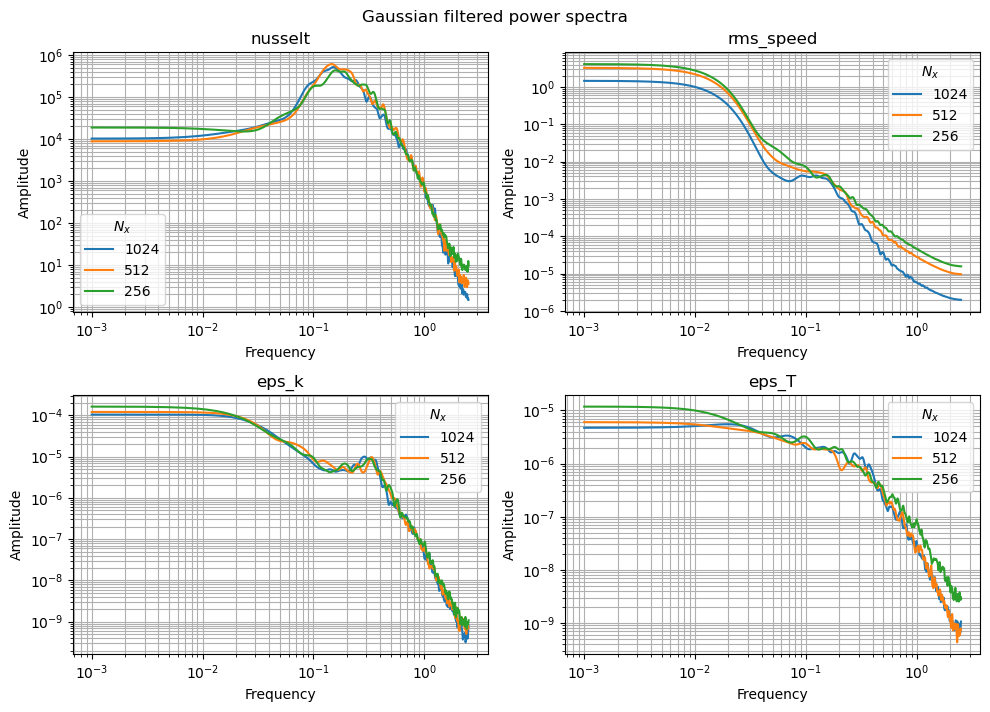

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
for ax, var in zip(axes.ravel(), ['nusselt', 'rms_speed', 'eps_k', 'eps_T']):
    for s in spectra:
        array = spectra[s][var].isel(freq_t=(spectra[s].freq_t > 0))
        ax.loglog(array.freq_t, gaussian_filter1d(array, sigma=10), label=s)
    ax.legend(title='$N_x$')
    ax.grid(True, which='both')
    ax.set(ylabel='Amplitude', xlabel='Frequency', title=var)

fig.tight_layout()
fig.suptitle('Gaussian filtered power spectra', y=1.01)

In [86]:
client.close()